<a href="https://www.kaggle.com/code/shedai/demand-prediction-in-retail?scriptVersionId=124504628" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/retail-data-set/file_out2.csv
/kaggle/input/retail-data-set/file_out.csv


# <p style="background-color:#BDBDBD;font-family:newtimeroman;color:#D3463F;font-size:150%;text-align:center;border-radius:10px 10px;">Retail Demand Forecasting</p>

In this project, I will be performing demand prediction / forecasting project with using the time series approach on the customer's records from a retail industry firm's database. Demand prediction is the practice of separating products into groups that reflect similarities among sales and behaviours in the sales data. I will divide products into two groups as predictable and unpredictable. 

- Unpredictable Products: Some of the products are unpredictable, like the rare products, new products or stopped products etc. During the demand prediction project, it is also important to seperate unpredictable products from the predictable ones. I will start with this seperation first, than continue to the predictions for the predictable data. 
- Predictable Products: These type of products have a good history in the sales data with multiple customers. I will focus on this part of the data and create time series predictions and forecastings. 



   <a id='top'></a>
<div class="list-group" id="list-tab" role="tablist">
<p style="background-color:#BDBDBD;font-family:newtimeroman;color:#D3463F;font-size:150%;text-align:center;border-radius:10px 10px;">TABLE OF CONTENTS</p>   
    
* [1. IMPORTING LIBRARIES](##1)
    
* [2. LOADING DATA](##2)
      
* [3. Detecting the Useful Data : DETERMINING THE UNPREDICTABLE DATA](##3)
    
* [4. DEMAND PREDICTION with ARIMA](##4)
    
* [5. DEMAND PREDICTION FOR SELECTED PRODUCTS](#5)
    
* [6. CONCLUSION](#6)
    
* [7. END](#7)

## <a id='top'></a>
<div class="list-group" id="list-tab" role="tablist">
<p style="background-color:#BDBDBD;font-family:newtimeroman;color:#D3463F;font-size:150%;text-align:center;border-radius:10px 10px;">1. Importing Libraries</p>  

In [2]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 35.3 MB/s eta 0:00:00


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from pmdarima import auto_arima

## <a id='top'></a>
<div class="list-group" id="list-tab" role="tablist">
<p style="background-color:#BDBDBD;font-family:newtimeroman;color:#D3463F;font-size:150%;text-align:center;border-radius:10px 10px;">2. Loading Data and Data Discovery</p>   

Loading the latest data set (Version 2.0), lets see its header:

In [4]:
df = pd.read_csv('/kaggle/input/retail-data-set/file_out2.csv')
df.head()

,Unnamed: 0,InvoiceID,Date,ProductID,TotalSales,Discount,CustomerID,Quantity
0,0,328,2019-12-27,1684,796.610169,143.389831,185,4
1,1,329,2019-12-27,524,355.932203,64.067797,185,2
2,2,330,2019-12-27,192,901.694915,162.305085,230,4
3,3,330,2019-12-27,218,182.754237,32.895763,230,1
4,4,330,2019-12-27,247,780.101695,140.418305,230,4


Deleting the useless columns, the id column. 

In [5]:
df.drop(df.columns[0],axis = 1, inplace = True)
df.head()

,InvoiceID,Date,ProductID,TotalSales,Discount,CustomerID,Quantity
0,328,2019-12-27,1684,796.610169,143.389831,185,4
1,329,2019-12-27,524,355.932203,64.067797,185,2
2,330,2019-12-27,192,901.694915,162.305085,230,4
3,330,2019-12-27,218,182.754237,32.895763,230,1
4,330,2019-12-27,247,780.101695,140.418305,230,4


Data unique distribution: We can visualize the number of unique records in each column:

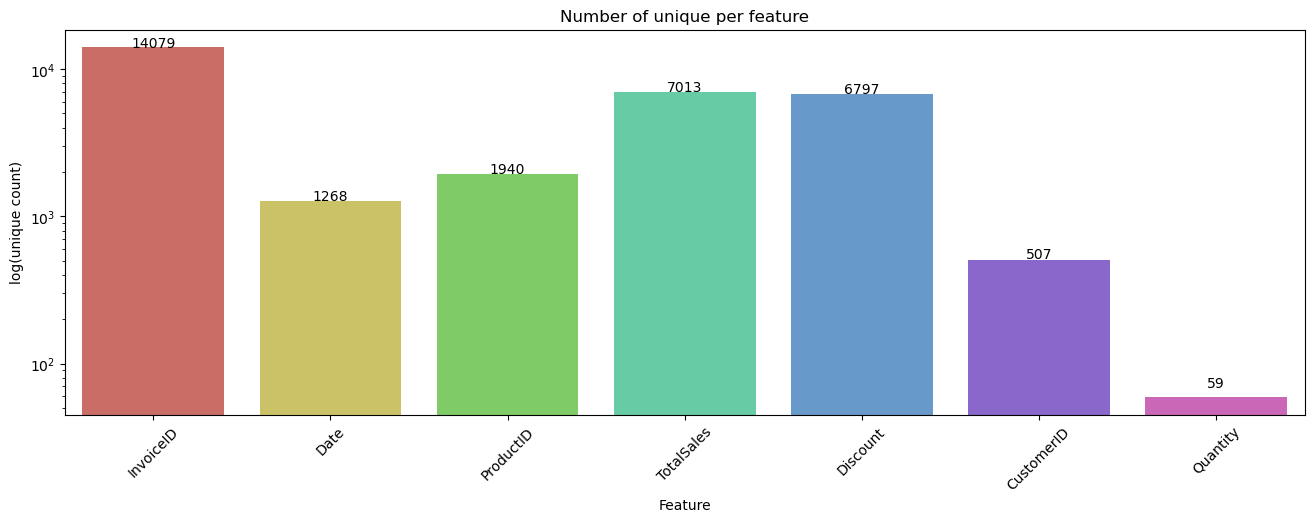

In [6]:

plt.figure(figsize=(16, 5))

cols = df.columns
uniques = [len(df[col].unique()) for col in cols]

ax = sns.barplot(x=cols, y=uniques, palette='hls', log=True)
ax.set(xlabel='Feature', ylabel='log(unique count)', title='Number of unique per feature')


for p, uniq in zip(ax.patches, uniques):
    ax.text(p.get_x() + p.get_width()/2.,
            uniq + 10,
            uniq,
            ha="center") 

ax.set_xticklabels(ax.get_xticklabels(), rotation=45);

Types of data columns:

In [7]:
df.dtypes

InvoiceID       int64
Date           object
ProductID       int64
TotalSales    float64
Discount      float64
CustomerID      int64
Quantity        int64
dtype: object

Data range of the data set (starting and ending dates for the data set)

In [8]:
df['Date'] = pd.to_datetime(df['Date'],format = '%Y-%m-%d' )
df.head()

,InvoiceID,Date,ProductID,TotalSales,Discount,CustomerID,Quantity
0,328,2019-12-27,1684,796.610169,143.389831,185,4
1,329,2019-12-27,524,355.932203,64.067797,185,2
2,330,2019-12-27,192,901.694915,162.305085,230,4
3,330,2019-12-27,218,182.754237,32.895763,230,1
4,330,2019-12-27,247,780.101695,140.418305,230,4


In [9]:
#date ranges between:
print(df['Date'].min(),' --- ', df['Date'].max())

2019-01-02 00:00:00  ---  2023-03-25 00:00:00


  ## <a id='top'></a>
<div class="list-group" id="list-tab" role="tablist">
<p style="background-color:#BDBDBD;font-family:newtimeroman;color:#D3463F;font-size:150%;text-align:center;border-radius:10px 10px;">3. Detecting the useful products </p>
    Now we can eliminate the useless products for the data analysis. There might be some cases like below:
    
- Products not selling anymore (old products and there are no recent records)
- Products just started selling (fresh new products and not enough data for the analysis)
- Rare products (Selling rarely and the products do not have enough records)
  
    

We start by eliminating the rare products, sold less than or equal to 100 lines of records.

In [10]:
df_products = df.groupby('ProductID').count()
# if number of sales for the product is less than 100 delete them 
df_products = df_products.iloc[:,0].to_frame()
df_products.columns = ['SaleCount']
df_products = df_products[df_products['SaleCount']>100]
df_products.head()
                          

,SaleCount
ProductID,
49,103
86,138
98,240
152,102
164,136


In [11]:
df_products.shape

(57, 1)

Number of products has been reduced to 57 from 1940. Now we can also check the first and last date of the product sales. Our approach will eliminate old products not sold recently and new products, just started selling. 

let's make recency date to 3 months. So, the products sold before 3 months and not sold in last 3 months will be eliminated. Also, the items just started in the last 3 months and has no sell before will be eliminated. 

In [12]:
df_products['FirstDate'] = df.groupby('ProductID').min()['Date']
df_products.head()

,SaleCount,FirstDate
ProductID,,
49,103,2019-03-22
86,138,2019-01-08
98,240,2019-01-07
152,102,2019-01-02
164,136,2019-04-08


Let's see the products with their latest sale date.

In [13]:
df_products['LastDate'] = df.groupby('ProductID').max()['Date']
df_products.head()

,SaleCount,FirstDate,LastDate
ProductID,,,
49,103,2019-03-22,2023-03-01
86,138,2019-01-08,2021-12-17
98,240,2019-01-07,2022-04-08
152,102,2019-01-02,2022-12-10
164,136,2019-04-08,2022-02-28


In [14]:
df_products.shape

(57, 3)

we have only 57 products left.

In [15]:
df_products.sort_values('LastDate', ascending = False).head(10)

,SaleCount,FirstDate,LastDate
ProductID,,,
1341,135,2019-07-12,2023-03-25
1830,577,2019-01-07,2023-03-25
1128,279,2019-01-02,2023-03-25
613,224,2022-02-17,2023-03-25
252,204,2019-01-02,2023-03-25
617,167,2022-02-17,2023-03-24
1724,165,2022-03-24,2023-03-24
1588,134,2019-01-16,2023-03-23
1347,285,2022-03-15,2023-03-22


We can see the product turnover rate is very high in the company. Even the most recently sold 10 products does not go back to 1 year. 

In [16]:
df_products['Duration'] = df_products['LastDate'] - df_products['FirstDate']
df_products.sort_values('Duration',ascending = True , inplace = True)
df_products.head()

,SaleCount,FirstDate,LastDate,Duration
ProductID,,,,
814,142,2019-01-23,2019-09-20,240 days
1724,165,2022-03-24,2023-03-24,365 days
1793,143,2019-09-30,2020-10-01,367 days
1347,285,2022-03-15,2023-03-22,372 days
617,167,2022-02-17,2023-03-24,400 days


Now we can also eliminate products less than 300 days of run. 

In [17]:
df_products = df_products[df_products['Duration']>timedelta(days=300)]
df_products.shape

(56, 4)

only 1 product has been eliminated by the length of run. Now we can check the recency of products by 3 months from the last date of the sales. We will assume the 3 months back from the last date of the recent sales. 

In [18]:
df_products = df_products[df_products['LastDate']>df['Date'].max() - timedelta(days=90)]
df_products.shape

(22, 4)

Only 22 products left for the prediction after the recency check. Now we can start the demand prediction. 

In [19]:
df_demand = df[df['ProductID'].isin(df_products.index)]
df_demand.head()

,InvoiceID,Date,ProductID,TotalSales,Discount,CustomerID,Quantity
5,330,2019-12-27,252,1123.966102,202.313898,230,4
6,330,2019-12-27,486,1251.084746,225.195254,230,4
22,334,2019-12-28,1475,711.864407,128.135593,420,4
30,340,2019-12-28,1498,389.830508,70.169492,254,2
34,342,2019-12-28,1498,714.237288,128.562712,254,4


Total number of records for the filtered products:

In [20]:
df_demand.shape

(4448, 7)

 ## <a id='top'></a>
<div class="list-group" id="list-tab" role="tablist">
<p style="background-color:#BDBDBD;font-family:newtimeroman;color:#D3463F;font-size:150%;text-align:center;border-radius:10px 10px;">4. Demand Prediction Algorithm </p>
    Now we can eliminate the useless products for the data analysis. There might be some cases like below:
    
- Products not selling anymore (old products and there are no recent records)
- Products just started selling (fresh new products and not enough data for the analysis)
- Rare products (Selling rarely and the products do not have enough records)
  
    

In [21]:
df_demand_test = df[df['ProductID'] == 1830]
df_demand_test = df_demand_test.groupby('Date').sum()
df_demand_test = df_demand_test[['TotalSales']]
pd.DatetimeIndex(df_demand_test.index).to_period('M')
df_demand_test.head()

,TotalSales
Date,
2019-01-07,216.949153
2019-01-08,915.254237
2019-01-09,457.627119
2019-01-14,869.491525
2019-01-15,889.830509


In [22]:
len(df_demand_test)

319

In [23]:
# Dickey-Fuller Test to City Hotel Data
SalesValues = df_demand_test.TotalSales
sales_product = adfuller(SalesValues)
print('ADF Statistic: %f' % sales_product[0])
print('p-value: %f' % sales_product[1])
print('Critical Values:')
for key, value in sales_product[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -5.630417
p-value: 0.000001
Critical Values:
	1%: -3.451
	5%: -2.871
	10%: -2.572


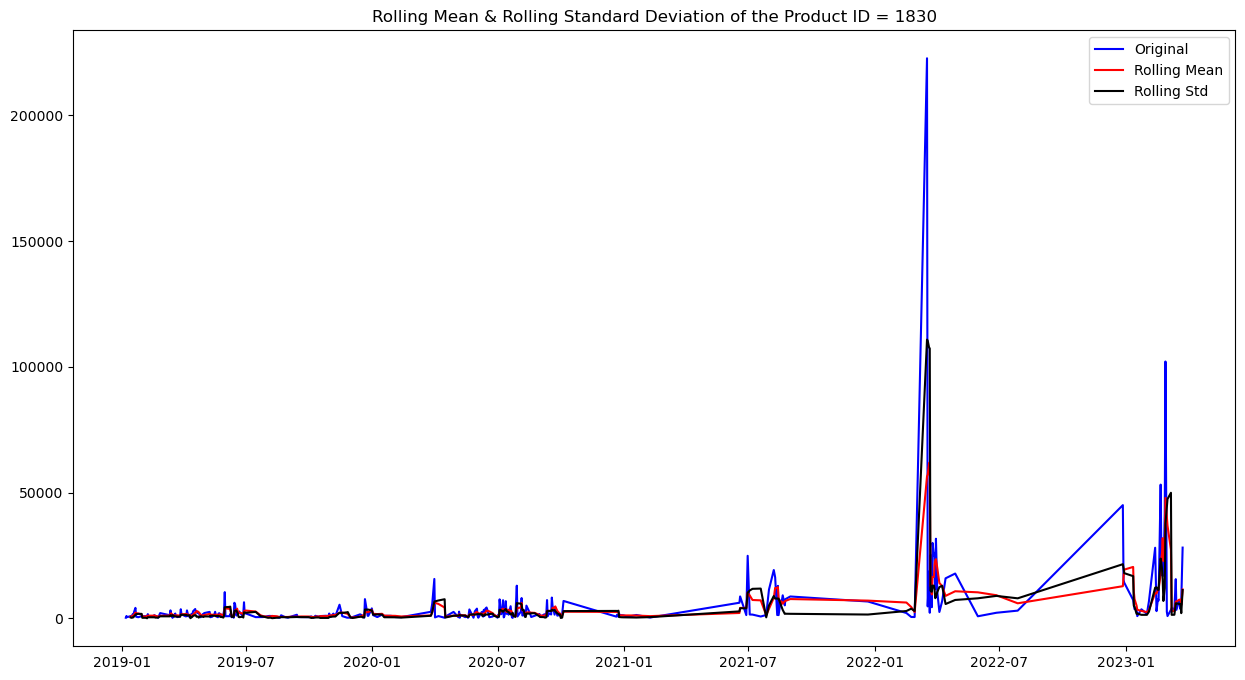

In [24]:
# Rolling Mean & Rolling Standard Deviation of City Hotel
plt.figure(figsize=(15, 8))
rolling_mean = SalesValues.rolling(window=4).mean()
rolling_std = SalesValues.rolling(window=4).std()
plt.plot(SalesValues, color='blue', label='Original')
plt.plot(rolling_mean, color='red', label='Rolling Mean')
plt.plot(rolling_std, color='black', label='Rolling Std')
plt.legend(loc='upper right')
plt.title('Rolling Mean & Rolling Standard Deviation of the Product ID = 1830')
plt.show()

In [25]:
# Fit auto_arima function to NumberOfGuests_CityWeekly Dataset
stepwise_fit = auto_arima(df_demand_test, start_p=1, start_q=1,
                          max_p=3, max_q=3, m=12,
                          start_P=0, seasonal=True,
                          d=None, D=1, trace=True,
                          error_action='ignore',
                          suppress_warnings=True,
                          stepwise=True)

stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=4.85 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=6951.113, Time=0.08 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=6884.672, Time=0.51 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=6806.243, Time=1.85 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=6949.573, Time=0.07 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=6953.000, Time=0.07 sec
 ARIMA(0,0,1)(1,1,1)[12] intercept   : AIC=6838.530, Time=1.01 sec
 ARIMA(0,0,1)(0,1,2)[12] intercept   : AIC=6838.488, Time=2.25 sec
 ARIMA(0,0,1)(1,1,0)[12] intercept   : AIC=6885.421, Time=0.46 sec
 ARIMA(0,0,1)(1,1,2)[12] intercept   : AIC=6840.446, Time=4.03 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=inf, Time=2.17 sec
 ARIMA(0,0,2)(0,1,1)[12] intercept   : AIC=6839.729, Time=1.05 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=6835.281, Time=0.72 sec
 ARIMA(1,0,2)(0,1,1)[12] intercept   : AIC=6841.319, Time=2.93 sec
 ARIMA(0,0,1)(0,1,1)[12]     

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  319
Model:             SARIMAX(0, 0, 1)x(0, 1, 1, 12)   Log Likelihood               -3399.121
Date:                            Tue, 04 Apr 2023   AIC                           6806.243
Time:                                    02:34:20   BIC                           6821.150
Sample:                                         0   HQIC                          6812.204
                                            - 319                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1061.6181    175.960      6.033      0.000     716.743    1406.493
ma.L1          0.0621      0.050      1.234      0.217      -0.037       0.161
ma.S.L12      -0.8502      0.027    -31.223      0.000      -0.904      -0.797
sigma2        2.6e+08      0.007   3.47e+10      0.000     2.6e+08     2.6e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.18   Jarque-Bera (JB):            243447.57
Prob(Q):                              0.67   Prob(JB):                         0.00
Heteroskedasticity (H):              60.13   Skew:                            10.28
Prob(H) (two-sided):                  0.00   Kurtosis:                       139.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.19e+24. Standard errors may be unstable.
"""

In [26]:
df_demand_test


,TotalSales
Date,
2019-01-07,216.949153
2019-01-08,915.254237
2019-01-09,457.627119
2019-01-14,869.491525
2019-01-15,889.830509
...,...
2023-03-16,3381.355932
2023-03-20,7118.644068
2023-03-22,3622.881356


In [27]:
modelSales = ARIMA(df_demand_test,
                  order=(1,0,0),
                  seasonal_order=(1,1,1, 12))

resultSales = modelSales.fit()

# Prediction of the Test data
predictionsSalesTest = resultSales.predict(len(df_demand_test), len(df_demand_test)+90, typ='levels').rename("Predictions")

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


we have created the ARIMA model and trained with the selected product data.

In [28]:
predictionsSalesTest.index = range(len(predictionsSalesTest))

In [29]:
predictionsSalesTest.index = [df_demand_test.index.max() + timedelta(days=x) for x in predictionsSalesTest.index]

Text(0, 0.5, 'Number of Guests')

<Figure size 1500x800 with 0 Axes>

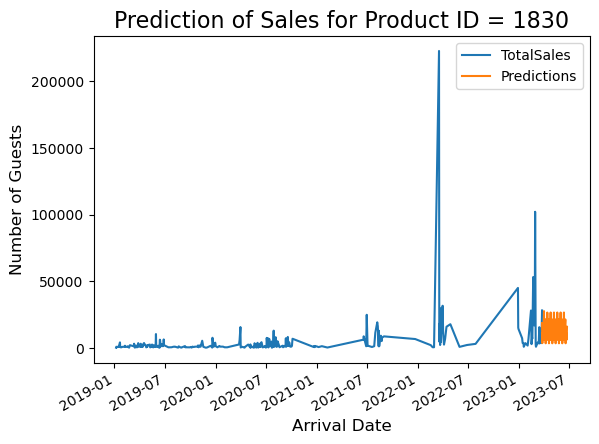

In [30]:
plt.figure(figsize=(15, 8))
df_demand_test.plot(legend=True)
predictionsSalesTest.plot(legend=True)
plt.title('Prediction of Sales for Product ID = 1830', fontsize=16)
plt.xlabel('Arrival Date', fontsize=12)
plt.ylabel('Number of Guests', fontsize=12)

After we have a demand prediction in time series, lets calculate the total demand per product. 

In [31]:
TotalDemand = predictionsSalesTest.sum()
TotalDemand

1078470.1593807347

## <a id='top'></a>
<div class="list-group" id="list-tab" role="tablist">
<p style="background-color:#BDBDBD;font-family:newtimeroman;color:#D3463F;font-size:150%;text-align:center;border-radius:10px 10px;">5. Demand Prediction for Selected Products</p> 
Now we can produce the demand prediction for all predictable products in a loop.

In [32]:
df_products.head()

,SaleCount,FirstDate,LastDate,Duration
ProductID,,,,
1724,165,2022-03-24,2023-03-24,365 days
1347,285,2022-03-15,2023-03-22,372 days
617,167,2022-02-17,2023-03-24,400 days
613,224,2022-02-17,2023-03-25,401 days
300,113,2020-08-04,2023-02-07,917 days


In [33]:
l_prodid = []
l_total_sales = []
for i in df_products.index:
    df_demand_test = df[df['ProductID'] == i]
    df_demand_test = df_demand_test.groupby('Date').sum()
    df_demand_test = df_demand_test[['TotalSales']]
    df_demand_test.index = pd.DatetimeIndex(df_demand_test.index).to_period('M')
    modelSales = ARIMA(df_demand_test,
                  order=(1,0,0),
                  seasonal_order=(1,1,1, 12)
                      ,enforce_stationarity=False)
    resultSales = modelSales.fit()
    predictionsSalesTest = resultSales.predict(len(df_demand_test), len(df_demand_test)+90, typ='levels').rename("Predictions")
    l_prodid += [i]
    l_total_sales += [predictionsSalesTest.sum()]
product_demands_table = pd.DataFrame(l_total_sales, index = l_prodid, columns = ['DemandPrediction'])
product_demands_table.head()

,DemandPrediction
1724,8.763902e+05
1347,1.197140e+06
617,1.888727e+05
613,8.810812e+05
300,6.265282e+05


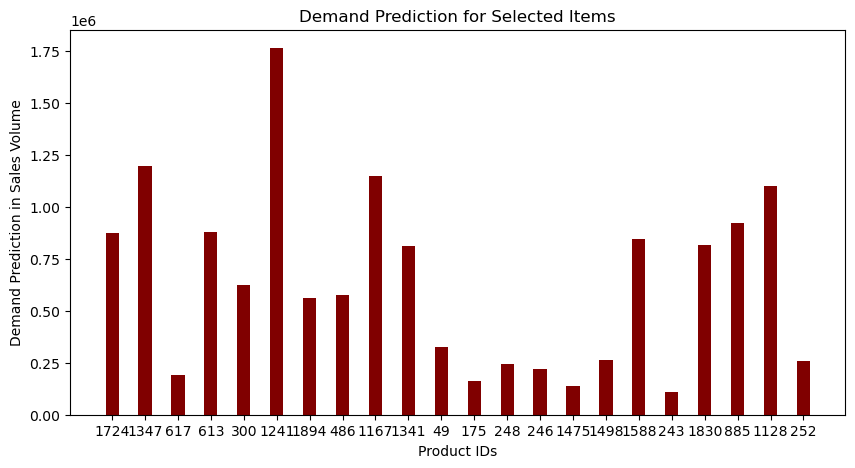

In [34]:
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
l_prodid_str = list(map(str, l_prodid))

plt.bar(l_prodid_str, l_total_sales, color ='maroon', width=0.4)
 
plt.xlabel("Product IDs")
plt.ylabel("Demand Prediction in Sales Volume")
plt.title("Demand Prediction for Selected Items")
plt.show()

## <a id='top'></a>
<div class="list-group" id="list-tab" role="tablist">
<p style="background-color:#BDBDBD;font-family:newtimeroman;color:#D3463F;font-size:150%;text-align:center;border-radius:10px 10px;">6. Conclusion</p> 
    We have started with a sales data in retail industry and created a demand prediction for next 90 weeks. The retail data has many problems with unpredictable products, such as stopped selling products, new products or not enough data for some of the products. After the exploratory data analysis (EDA) we have eliminated these unpredictable products. Next, we have applied ARIMA with the parameters from auto-arima library. Although the hyper parameter optimization can be fine-tuned for each of the products, this part of study left untouched. Finally we have applied the ARIMA predictions for all the predictable products and output the final histogram of predictions. 

## <a id='top'></a>
<div class="list-group" id="list-tab" role="tablist">
<p style="background-color:#BDBDBD;font-family:newtimeroman;color:#D3463F;font-size:150%;text-align:center;border-radius:10px 10px;">7. END</p> 
    Hello, my name is Sadi Evren SEKER and this is a notebook just for fun. You can reach me by <a href = "https://www.sadievrenseker.com">https://www.sadievrenseker.com</a> (my homepage) or my udemy courses ( <a href="https://www.udemy.com/user/sadievrenseker/">https://www.udemy.com/user/sadievrenseker/</a> ) or my youtube channel ( <a href ="https://www.youtube.com/@dataconcepts">https://www.youtube.com/@dataconcepts </a> ) or my linkedin profile ( <a href = "https://www.linkedin.com/in/sadiseker/"> https://www.linkedin.com/in/sadiseker/</a>) , bests.